In [33]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Load Dataset

In [67]:
dataset = load_dataset('uit-nlp/vietnamese_students_feedback')
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

In [68]:
#Chuyển dataset thành dataframe
train_df = dataset['train'].to_pandas()
print('Train:', train_df.shape)
val_df = dataset['validation'].to_pandas()
print('Val: ', val_df.shape)
test_df = dataset['test'].to_pandas()
print('Test: ', test_df.shape)

#Gộp các df lại thành 1 df tên sentiment_data
sentiment_data = pd.concat([train_df, val_df, test_df], ignore_index = True)

#Xáo trộn thứ tự các dòng dataframe tránh việc mô hình học theo thứ tự dữ liệu, dẫn đến hiện tượng overfitting(học thuộc)
sentiment_data = sentiment_data.sample(frac = 1).reset_index(drop = True)
print('Sentiment data:', sentiment_data.shape)

#Đổi tên cột
sentiment_data = sentiment_data.rename(columns={'sentence' : 'comment','sentiment' : 'label'})
sentiment_data.head()

Train: (11426, 3)
Val:  (1583, 3)
Test:  (3166, 3)
Sentiment data: (16175, 3)


,comment,label,topic
0,"nhiệt tình , dễ gần , hình thức giảng dạy dễ h...",2,0
1,hơi khó .,0,0
2,cần có nhiều thiết bị trực quan hơn .,0,2
3,"môn học còn khá nặng nề , không ứng dụng thực ...",0,1
4,"giảng viên tận tình , giảng dạy hay , chất lượ...",2,0


## 2. Data preprocessing

### 2.1 Duplicated

In [69]:
# Đếm số hàng trùng lặp và xóa
print('Số dữ liệu bị lặp: ', sentiment_data['comment'].duplicated().sum())
sentiment_data = sentiment_data.drop_duplicates('comment')

# Kiểm tra lại sau khi xóa
print('Số dữ liệu bị lặp sau khi xóa: ', sentiment_data['comment'].duplicated().sum())

sentiment_data = sentiment_data.reset_index(drop = True)
sentiment_data.shape

Số dữ liệu bị lặp:  1
Số dữ liệu bị lặp sau khi xóa:  0


(16174, 3)

### 2.2 Missing

In [70]:
# Kiểm tra giá trị missing
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16174 entries, 0 to 16173
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  16174 non-null  object
 1   label    16174 non-null  int64 
 2   topic    16174 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 379.2+ KB


### 2.3 Over-sampling

In [71]:
def visualization_labels(sentiment_data):
    #Khảo sát
    label_counts = sentiment_data['label'].value_counts().sort_index()
    
    print('BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ:', sentiment_data.shape)
    print('CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:\n ', label_counts)
    
    #Trực quan hóa
    plt.figsize = (9,9)
    
    labels = ['Tiêu cực', 'Trung lập', 'Tích cực']
    mycolors = ['#009299', '#7ed957', '#00b980']
    plt.pie(label_counts, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = mycolors)
    plt.title('Tỉ lệ số nhãn trong đánh giá')

BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ: (16174, 3)
CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:
  label
0    7439
1     698
2    8037
Name: count, dtype: int64


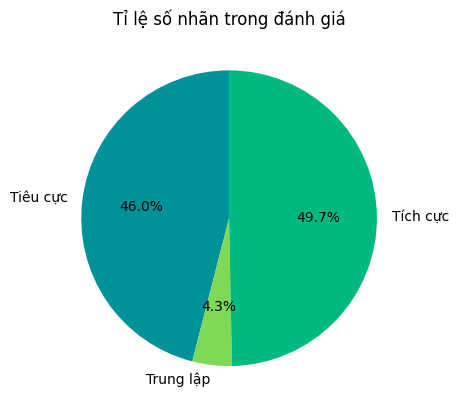

In [72]:
visualization_labels(sentiment_data)

In [73]:
from sklearn.utils import resample

train_comments = sentiment_data['comment'].values
# print(train_comments)

train_labels = sentiment_data['label'].values
# print(train_labels)

# Tìm chỉ số các câu trung lập(label=1)
neutral_indices = np.where(train_labels == 1)[0]

oversample_size = len(train_labels[train_labels ==0]) - len(neutral_indices)

oversampled_neutral_indices = resample(neutral_indices,
                                       replace = True,
                                       n_samples = oversample_size,
                                       random_state = 42)
oversampled_neutral_comments = train_comments[oversampled_neutral_indices]

train_comments_oversampled = np.concatenate([train_comments,oversampled_neutral_comments], axis = 0)
train_labels_oversampled = np.concatenate([train_labels, np.array([1]*oversample_size)], axis = 0)

In [74]:
sentiment_data = pd.DataFrame({
    'comment' : train_comments_oversampled,
    'label' : train_labels_oversampled
})

sentiment_data = sentiment_data_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ: (22915, 2)
CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:
  label
0    7439
1    7439
2    8037
Name: count, dtype: int64


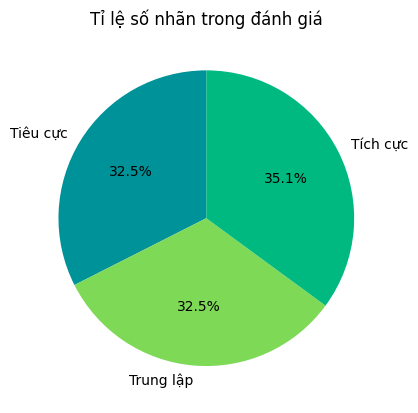

In [75]:
visualization_labels(sentiment_data)

### 2.4 Data normaliztion

In [76]:
import regex as re
import string
from underthesea import word_tokenize, text_normalize

#CHUẨN HÓA DỮ LIỆU
#Sử dụng hàm nhận diện icon 
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F" 
                u"\U0001F300-\U0001F5FF" 
                u"\U0001F680-\U0001F6FF" 
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0" 
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    
    text=text.lower()  #chuyển toàn bộ text về chữ thường 
    text=re.sub(emoji_pattern," ",text)    #loại bỏ icon
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)  #loại bỏ các ký chữ lặp trong từ(aaaaabbbb--> ab)


    #Đảm bảo khoảng trắng trước và sau giữa các dấu câu --> se , ti
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)

    #Xóa bớt các dấu câu lặp lại --> !!!!->!
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    #Loại bỏ các dấu câu hoặc khoảng trắng ở đâu và cuối câu
    text=text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    #Loại bỏ tất cả các dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))

    #Loại bỏ các khoảng trắng dư thừa trong câu
    text = re.sub(r"\s+", " ", text)

    #Tách từ 
    text = text_normalize(text)
    text = word_tokenize(text, format="text")

    return text

In [77]:
print('Câu gốc: ', sentiment_data['comment'][6])
print('Chuẩn hóa: ', clean_text(sentiment_data['comment'][6]))

Câu gốc:  chỉ là đôi khi thầy hơi nóng tính lúc làm việc .
Chuẩn hóa:  chỉ là đôi_khi thầy hơi nóng_tính lúc làm_việc


In [78]:
sentiment_data['corpus'] = sentiment_data['comment'].map(lambda text: clean_text(text))                                                     
sentiment_data.head(20)

,comment,label,corpus
0,biết hai ngôn ngữ sẽ dễ gây ấn tượng với nhà t...,2,biết hai ngôn_ngữ sẽ dễ gây ấn_tượng với nhà t...
1,"dạ , cho em hỏi là trường mình là tạo sao khôn...",1,dạ cho em hỏi là trường mình là tạo sao không ...
2,thầy dạy rất tận tâm .,2,thầy dạy rất tận_tâm
3,khả năng truyền đạt còn hạn chế .,0,khả_năng truyền_đạt còn hạn_chế
4,giảng viên thường dạy quá giờ ( khoảng 30 phút...,0,giảng_viên thường dạy quá giờ khoảng 30 phút ả...
5,các buổi thuyết trình .,1,các buổi thuyết_trình
6,chỉ là đôi khi thầy hơi nóng tính lúc làm việc .,1,chỉ là đôi_khi thầy hơi nóng_tính lúc làm_việc
7,"tuy nhiên , bản chất môn học vẫn chán nên dù c...",0,tuy_nhiên bản_chất môn_học vẫn chán nên dù cô ...
8,"giảng viên giảng dạy nhiệt tình , bám sát nội ...",2,giảng_viên giảng_dạy nhiệt_tình bám sát nội_du...
9,nói chung cũng tạm được .,1,nói_chung cũng tạm được


### 2.5 Visualization

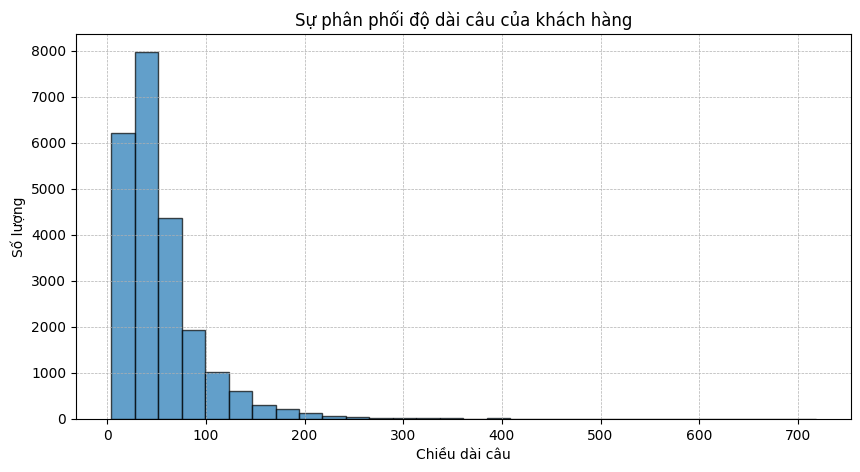

In [81]:
#Xem chiều dài của comment tập trung chủ yếu bao nhiêu 
lengths = sentiment_data['comment'].apply(len)

#Biểu đồ histogram
plt.figure(figsize=(10,5))
plt.hist(lengths, edgecolor='k', bins=30, alpha=0.7)#bin=30 chia khoảng giá trị thành 30 nhóm 
plt.title('Sự phân phối độ dài câu của khách hàng')
plt.xlabel('Chiều dài câu')
plt.ylabel('Số lượng')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

Số tất cả từ: 16001
Số từ xuất hiện nhiều nhất top 15: [('em cảm_ơn', 40), ('không có điều gì', 27), ('không có', 26), ('thân', 26), ('cảm_ơn', 24), ('cảm_ơn thầy', 23), ('không', 21), ('nội_dung ôn_tập mà giảng_viên cung_cấp đầy_đủ và đáp_ứng được cho sinh_viên hoàn_thành các kỳ thi', 20), ('cách truyền_đạt kiến_thức cho sinh_viên', 20), ('khả_năng truyền_đạt chưa thực_sự xuất_sắc', 19), ('đưa ra các bài_tập áp_dụng', 19), ('không ý_kiến thêm', 19), ('lớp có 3 thầy nhưng không biết thầy wzjwz282 3 thầy đó là doubledot wzjwz283 wzjwz284 wzjwz285', 19), ('môn_học này giúp chúng_em hiểu ra những vấn_đề cơ_bản', 19), ('tạm tạm', 18)]


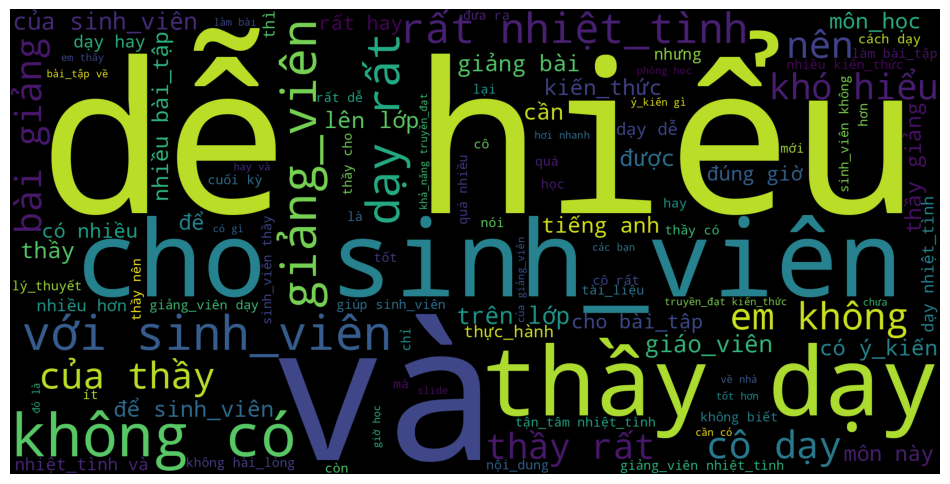

In [84]:
import nltk
import wordcloud

#XEM TRẠNG THÁI BAN ĐẦU CHƯA DỰ ĐOÁN CỦA BỘ DỮ LIỆU 

#Lọc bỏ các khoảng trắng chỉ lấy chữ
all_words= [token for token in sentiment_data['corpus'].tolist() if token and token!=' ']
 
corpus=' '.join(all_words)   #Nối lại thành chuỗi
all_words = nltk.FreqDist(all_words)  #Tính tần suất xuất hiện của từng từ trong danh sách 

print('Số tất cả từ: {}'.format(len(all_words)))
print('Số từ xuất hiện nhiều nhất top 15: {}'.format(all_words.most_common(15)))


plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)

plt.axis("off")  #tắt hiển thị các trục 
plt.imshow(word_cloud)


## 3. Data preparation

In [93]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle

from sklearn.model_selection import train_test_split

input_pre = sentiment_data['corpus'].tolist()
label_with_accent = sentiment_data['label'].tolist()

label_tf = to_categorical(label_with_accent, num_classes = 3)
input_pre = [str(item) for item in input_pre] #Biến đổi nhãn (label) thành ma trận on-hot encoding.

#Phân tách dữ liệu văn bản đầu vào
tokenizer_data = Tokenizer(oov_token = '<00V>') # gán các từ chưa máy chưa học thì sẽ gán bằng mã '<00V>' để tránh lỗi khi xử lý 
tokenizer_data.fit_on_texts(input_pre)  # tách từ + đếm số lần xuất hiện taoh thành một từ điển 

#Chuyển đổi văn bản thành vector số
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)   #Biến đổi các văn bản trong input_pre (chuỗi) thành danh sách các chuỗi số,tương ứng từ được thay thế bằng chỉ số tương ứng trong từ điển
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=45)  # Làm cho tất cả các chuỗi trong tokenized_data_text có cùng độ dài (ở đây là 45), nếu <45 thì thêm 0, ngược thì thì cắt bớt

#Lưu tokenizer(word_index) vào file nhằm mục đích tái sử dụng
pickle.dump(tokenizer_data, open('tokenizer_data.pkl','wb'))

# Chuyển vec_data thành numpy
vec_data = np.array(vec_data)  
print("Input data shape:", vec_data.shape)

# Lấy size từ vựng
data_vocab_size = len(tokenizer_data.word_index) + 1
print("Data vocab size:", data_vocab_size)

# Chia dữ liệu training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
'''
    vec_data: là dữ liệu đầu vào sau khi đã sử lý với chiều dài là 45
    label_tf: là nhãn tương ứng với dữ liệu đầu vào đã được mã hóa ở dạng one-host encoding
    test_size=0.2 : lấy 20% cho tập validation và còn lại 80% cho tập training
    random_state=42: đảm bảo dữ liệu được lấy ngẫu nhiên 
'''
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
'''
    X_train: là dữ liệu đầu vào
    y_train: là nhãn tương ứng với dữ liệu đầu vào
    test_size=0.1 : lấy 10% cho tập test từ tập training
    random_state=42: đảm bảo dữ liệu được lấy ngẫu nhiên 
'''
#training: chiếm 78%
# validation: chiếm 20%
# test: 8%


print("Training sample:", len(X_train))
print("Validation sample:", len(X_val))
print("Test sample:", len(X_test))

input data shape: (22915, 45)
Data vocab size: 2817
Training sample: 16498
Validation sample: 4583
Test sample: 1834
